## TPE Tuning

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
import os

from sklearn.pipeline import Pipeline
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SelectByShuffling

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from boruta import BorutaPy
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import train_test_split
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor

import xgboost as xgb
from xgboost import XGBClassifier
from ngboost import NGBClassifier
from ngboost.distns import k_categorical

from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, balanced_accuracy_score

import optuna

In [3]:
# Import dataset
load_dotenv()
dataset_path=os.getenv("DATASET_PATH")
dataset = pd.read_csv(dataset_path)
dataset.head()

,RID,Gender,Ageatscreening,Diagnosis,MMSE0m,HipsASMbaseline,HipsContrastbaseline,HipsCorelationbaseline,HipsVariancebaseline,HipsSumAveragebaseline,...,ERCsContrastbaseline,ERCsCorelationbaseline,ERCsVariancebaseline,ERCsSumAveragebaseline,ERCsSumVariancebaseline,ERCsEntropybaseline,ERCsClusterShadebaseline,ERCs_thicknessbaseline,ERCsVolumebaseline,HipposcampusVolumebaseline
0,3,0,81.3479,3,20.0,NaN,158.27,0.63,218.30,28.37,...,253.10,0.40,208.65,23.39,581.50,NaN,-2568.19,2.31,1176.0,3047.0
1,4,0,67.6904,1,27.0,0.06,147.64,0.55,173.64,44.72,...,220.88,0.48,215.70,33.74,641.90,3.33,4113.01,2.76,1942.0,3449.0
2,5,0,73.8027,0,29.0,0.10,199.66,0.55,222.27,41.18,...,220.37,0.54,232.18,29.18,708.36,2.87,-1388.41,3.18,2044.0,3441.0
3,8,1,84.5945,0,28.0,0.08,184.21,0.53,201.55,43.04,...,198.42,0.54,220.48,26.68,683.50,2.77,-2506.55,2.68,1959.0,2875.0
4,10,1,73.9726,3,24.0,0.11,233.02,0.48,229.88,39.46,...,196.55,0.53,210.63,26.60,645.95,2.72,-1164.02,2.64,1397.0,2700.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    dataset.drop("Diagnosis", axis=1),  
    dataset["Diagnosis"],  
    test_size=0.3,  
    random_state=42,  
)

In [5]:
imputer_missForest = IterativeImputer(
    estimator=ExtraTreesRegressor(random_state=42),
    random_state=42,
)

imputer_missForest.fit(X_train)
X_train_missForest = imputer_missForest.transform(X_train)
X_test_missForest = imputer_missForest.transform(X_test)

c:\Users\steve\Desktop\Notebooks\Thesis-Project\venv\Lib\site-packages\sklearn\impute\_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [6]:
X_train_missForest_t = pd.DataFrame(
    X_train_missForest, 
    columns=X_train.columns, 
    index=X_train.index  # Critical fix
)
X_test_missForest_t = pd.DataFrame(
    X_test_missForest, 
    columns=X_test.columns, 
    index=X_test.index  # Critical fix
)

In [7]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=1, variables=None, missing_values='raise')),
    ('quasi-constant', DropConstantFeatures(tol=0.998, variables=None, missing_values='raise')),
    ('duplicated', DropDuplicateFeatures()),
])

pipe.fit(X_train_missForest_t)

Pipeline(steps=[('constant', DropConstantFeatures()),
                ('quasi-constant', DropConstantFeatures(tol=0.998)),
                ('duplicated', DropDuplicateFeatures())])

In [8]:
X_train_t = pipe.transform(X_train_missForest_t)
X_test_t = pipe.transform(X_test_missForest_t)

X_train_t.shape, X_test_t.shape

((425, 23), (183, 23))

In [9]:
model = RandomForestClassifier(random_state=42,)

# let's initialize Boruta
sel = BorutaPy(
    verbose=2,
    estimator=model,
    n_estimators='auto',
)

sel.fit(X_train_t.values, y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	23
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	4
Tentative: 	8
Rejected: 	11
Iteration: 	9 / 100
Confirmed: 	4
Tentative: 	8
Rejected: 	11
Iteration: 	10 / 100
Confirmed: 	4
Tentative: 	8
Rejected: 	11
Iteration: 	11 / 100
Confirmed: 	4
Tentative: 	8
Rejected: 	11
Iteration: 	12 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	13 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	14 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	15 / 100
Confirmed: 	6
Tentative: 	6
Rejected: 	11
Iteration: 	16 / 100
Confirmed: 	6
Tentative: 	5
Rejected: 	12
I

BorutaPy(estimator=RandomForestClassifier(n_estimators=46,
                                          random_state=RandomState(MT19937) at 0x22AAC513140),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x22AAC513140, verbose=2)

In [10]:
# Store selected feature names before transformation
selected_features = X_train_t.columns[sel.support_]
selected_features

Index(['RID', 'Ageatscreening', 'MMSE0m', 'HipsEntropybaseline',
       'ERCsContrastbaseline', 'ERCs_thicknessbaseline', 'ERCsVolumebaseline',
       'HipposcampusVolumebaseline'],
      dtype='object')

In [11]:
# Transform training and test sets using selected features
X_train_t = X_train_t[selected_features]
X_test_t = X_test_t[selected_features]

X_train_t.shape, X_test_t.shape

((425, 8), (183, 8))

## TPE

In [98]:
def objective(trial):
    
    classifier_name = trial.suggest_categorical("classifier", ["RF", "XGBoost", "NGBoost"])
    
    skf = StratifiedKFold(n_splits=5,
                             shuffle=True,
                             random_state=42,
        )
    
    if classifier_name == "RF":
        
        rf_n_estimators = trial.suggest_int("rf_n_estimators", 100, 500)
        rf_criterion = trial.suggest_categorical("rf_criterion", ['gini', 'entropy'])
        rf_max_depth = trial.suggest_int("rf_max_depth", 2, 4)
        rf_min_samples_split = trial.suggest_float("rf_min_samples_split", 0.001, 0.2)
        rf_max_features = trial.suggest_categorical("rf_max_features", ["sqrt", "log2", None])
        rf_min_samples_leaf = trial.suggest_float("rf_min_samples_leaf", 0.001, 0.1)
        rf_class_weight = trial.suggest_categorical("rf_class_weight", ["balanced", "balanced_subsample"])
        
        model = RandomForestClassifier(n_estimators=rf_n_estimators, 
                                       criterion=rf_criterion,
                                        max_depth=rf_max_depth,
                                        min_samples_split=rf_min_samples_split,
                                        max_features=rf_max_features,
                                        min_samples_leaf=rf_min_samples_leaf,
                                        random_state=42, 
                                        class_weight=rf_class_weight)
        
    elif classifier_name == "XGBoost":
        
        xgb_n_estimators = trial.suggest_int("xgb_n_estimators", 100, 500)
        xgb_max_depth = trial.suggest_int("xgb_max_depth", 2, 4)
        xgb_learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.3)
        xgb_subsample = trial.suggest_float("xgb_subsample", 0.5, 1.0)
        xgb_colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0)
        xgb_min_child_weight = trial.suggest_int("xgb_min_child_weight", 1, 10)
        xgb_gamma = trial.suggest_float("xgb_gamma", 0.0, 5.0)

        model = XGBClassifier(
            n_estimators=xgb_n_estimators,
            max_depth=xgb_max_depth,
            learning_rate=xgb_learning_rate,
            subsample=xgb_subsample,
            colsample_bytree=xgb_colsample_bytree,
            min_child_weight=xgb_min_child_weight,
            gamma=xgb_gamma,
            objective="multi:softprob",
            num_class=len(set(y_train))
        )
    
    else:
        
        ngb_n_estimators = trial.suggest_int("ngb_n_estimators", 100, 500)
        ngb_learning_rate = trial.suggest_float("ngb_learning_rate", 0.01, 0.1, log=True)
        ngb_base_depth = trial.suggest_int("ngb_depth", 3, 5)        
        model = NGBClassifier(Dist=k_categorical(len(np.unique(y_train))),
                              n_estimators=ngb_n_estimators,
                              learning_rate=ngb_learning_rate,
                              Base=DecisionTreeRegressor(criterion="friedman_mse", max_depth=ngb_base_depth),
                              verbose=False) 

    score = cross_val_score(model, X_train_t, y_train, scoring="balanced_accuracy", cv=skf)
    
    accuracy = score.mean()
    
    return accuracy

In [ ]:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
)

study.optimize(objective, n_trials=30)

[I 2025-03-15 02:37:06,876] A new study created in memory with name: no-name-d6a19e0a-f0f5-4f8b-94a9-2526ff1101c0
[I 2025-03-15 02:37:19,221] Trial 0 finished with value: 0.5658928364100777 and parameters: {'classifier': 'NGBoost', 'ngb_n_estimators': 109, 'ngb_learning_rate': 0.012694926916636944, 'ngb_depth': 4}. Best is trial 0 with value: 0.5658928364100777.
[I 2025-03-15 02:37:21,332] Trial 1 finished with value: 0.549639042311456 and parameters: {'classifier': 'RF', 'rf_n_estimators': 102, 'rf_criterion': 'gini', 'rf_max_depth': 2, 'rf_min_samples_split': 0.14065932132685594, 'rf_max_features': None, 'rf_min_samples_leaf': 0.07521979742150296, 'rf_class_weight': 'balanced'}. Best is trial 0 with value: 0.5658928364100777.
[I 2025-03-15 02:37:24,946] Trial 2 finished with value: 0.5539507555024796 and parameters: {'classifier': 'RF', 'rf_n_estimators': 204, 'rf_criterion': 'gini', 'rf_max_depth': 3, 'rf_min_samples_split': 0.15292668866112505, 'rf_max_features': 'log2', 'rf_min_sa

In [93]:
study.best_params


{'classifier': 'XGBoost',
 'xgb_n_estimators': 415,
 'xgb_max_depth': 2,
 'xgb_learning_rate': 0.29552458314604074,
 'xgb_subsample': 0.5125457513436893,
 'xgb_colsample_bytree': 0.6317024898147148,
 'xgb_min_child_weight': 1,
 'xgb_gamma': 2.7787225011804324}

In [94]:
study.best_value


0.5957297523676834

In [95]:
r = study.trials_dataframe()

r.head()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_ngb_depth,params_ngb_learning_rate,params_ngb_n_estimators,params_rf_class_weight,...,params_rf_min_samples_split,params_rf_n_estimators,params_xgb_colsample_bytree,params_xgb_gamma,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_min_child_weight,params_xgb_n_estimators,params_xgb_subsample,state
0,0,0.581426,2025-03-15 02:30:32.067999,2025-03-15 02:30:35.016779,0 days 00:00:02.948780,XGBoost,NaN,NaN,NaN,NaN,...,NaN,NaN,0.708352,1.142906,0.120409,4.0,5.0,342.0,0.914017,COMPLETE
1,1,0.546902,2025-03-15 02:30:35.019773,2025-03-15 02:30:42.024545,0 days 00:00:07.004772,RF,NaN,NaN,NaN,balanced,...,0.014062,285.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
2,2,0.551757,2025-03-15 02:30:42.026548,2025-03-15 02:30:56.354261,0 days 00:00:14.327713,RF,NaN,NaN,NaN,balanced_subsample,...,0.162357,499.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE
3,3,0.562173,2025-03-15 02:30:56.392265,2025-03-15 02:30:58.728673,0 days 00:00:02.336408,XGBoost,NaN,NaN,NaN,NaN,...,NaN,NaN,0.614478,4.305345,0.012005,3.0,4.0,167.0,0.892262,COMPLETE
4,4,0.532734,2025-03-15 02:30:58.736972,2025-03-15 02:31:06.553526,0 days 00:00:07.816554,RF,NaN,NaN,NaN,balanced_subsample,...,0.190201,233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,COMPLETE


C:\Users\steve\AppData\Local\Temp\ipykernel_12704\2963345091.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig = optuna.visualization.matplotlib.plot_optimization_history(study)


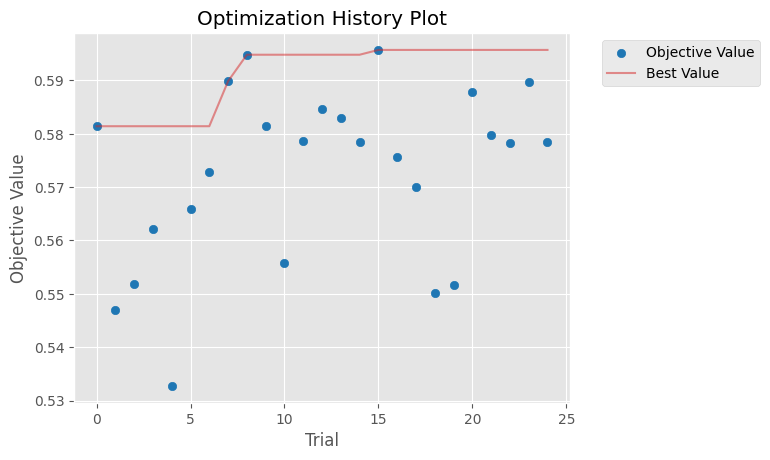

In [96]:
fig = optuna.visualization.matplotlib.plot_optimization_history(study)


In [117]:
import time

def eval_model(classifier_name, model, X_train, X_test, y_train, y_test):
        
        start_time = time.time()
        # Get predicted probabilities for ROC AUC
        pred_train_proba = model.predict_proba(X_train)
        pred_test_proba = model.predict_proba(X_test)
        
        # Get predicted accuracy values
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        
        # Calculate metrics
        metrics_train = {
                "accuracy": round(accuracy_score(y_train, pred_train), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_train, pred_train), 3),
                "precision": round(precision_score(y_train, pred_train, average="weighted"), 3),
                "recall": round(recall_score(y_train, pred_train, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_train, pred_train, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_train, pred_train_proba, average="weighted", multi_class="ovr"),3,),
        }
        
        metrics_test = {
                "accuracy": round(accuracy_score(y_test, pred_test), 3),
                "balanced_accuracy": round(balanced_accuracy_score(y_test, pred_test), 3),
                "precision": round(precision_score(y_test, pred_test, average="weighted"), 3),
                "recall": round(recall_score(y_test, pred_test, average="weighted"), 3),
                "f1_weighted": round(f1_score(y_test, pred_test, average="weighted"), 3),
                "roc_auc_ovr_weighted": round(roc_auc_score(y_test, pred_test_proba, average="weighted", multi_class="ovr"),3,),
        }
                
        elapsed_time = time.time() - start_time
    
        # Create the DataFrame without additional rounding
        pred_metrics_df = pd.DataFrame({
                "Feature Selection": "Boruta",
                "Classifier": classifier_name,
                "Classification Time": round(elapsed_time, 3),
                "Total Features": len(X_train.columns),
                "Metric": metrics_train.keys(),
                "Train data": metrics_train.values(),
                "Test data": metrics_test.values(),
    })
        
        return pred_metrics_df

In [118]:
results = "filtered"
prediction_df_report = None

if results == "all":
    pred_rf_n = eval_model("Random Forest", trained_rf_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)

    pred_xgb_n = eval_model("XGBoost", trained_xgb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)

    pred_ngb_n = eval_model("NGBoost", trained_ngb_n, X_train_missForest_t, X_test_missForest_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_n, pred_rf_t, pred_xgb_n, pred_xgb_t, pred_ngb_n, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])
        
elif results == "filtered":
    pred_rf_t = eval_model("Random Forest", trained_rf_t, X_train_t, X_test_t, y_train, y_test)
    pred_xgb_t = eval_model("XGBoost", trained_xgb_t, X_train_t, X_test_t, y_train, y_test)
    pred_ngb_t = eval_model("NGBoost", trained_ngb_t, X_train_t, X_test_t, y_train, y_test)
    
    prediction_df = pd.concat([pred_rf_t, pred_xgb_t, pred_ngb_t])
    prediction_df_report = prediction_df.set_index(["Feature Selection", "Classifier", "Classification Time", "Total Features", "Metric"])

prediction_df_report

Train data  \
Feature Selection Classifier    Classification Time Total Features Metric                             
Boruta            Random Forest 0.139               9              accuracy                   0.840   
                                                                   balanced_accuracy          0.849   
                                                                   precision                  0.850   
                                                                   recall                     0.840   
                                                                   f1_weighted                0.838   
                                                                   roc_auc_ovr_weighted       0.966   
                  XGBoost       0.118               9              accuracy                   1.000   
                                                                   balanced_accuracy          1.000   
                                                                   precision                  1.000   
                                                                   recall                     1.000   
                                                                   f1_weighted                1.000   
                                                                   roc_auc_ovr_weighted       1.000   
                  NGBoost       0.408               9              accuracy                   0.744   
                                                                   balanced_accuracy          0.655   
                                                                   precision                  0.733   
                                                                   recall                     0.744   
                                                                   f1_weighted                0.712   
                                                                   roc_auc_ovr_weighted       0.935   

                                                                                         Test data  
Feature Selection Classifier    Classification Time Total Features Metric                           
Boruta            Random Forest 0.139               9              accuracy                  0.563  
                                                                   balanced_accuracy         0.556  
                                                                   precision                 0.562  
                                                                   recall                    0.563  
                                                                   f1_weighted               0.558  
                                                                   roc_auc_ovr_weighted      0.839  
                  XGBoost       0.118               9              accuracy                  0.590  
                                                                   balanced_accuracy         0.568  
                                                                   precision                 0.575  
                                                                   recall                    0.590  
                                                                   f1_weighted               0.577  
                                                                   roc_auc_ovr_weighted      0.841  
                  NGBoost       0.408               9              accuracy                  0.596  
                                                                   balanced_accuracy         0.572  
                                                                   precision                 0.577  
                                                                   recall                    0.596  
                                                                   f1_weighted               0.553  
                                                                   roc_auc_ovr_weighted      0.828